In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt 
from tqdm import tqdm

In [2]:
data=np.load(r'/Volumes/KINGSTON/Synthetic_data_no_defect/2025_11_18_sample_100x100x5mm_no_defect_isotropic_gaussian_heat_no_conv_cond_5.npz',allow_pickle=True)

In [3]:
data['meta']

array([['time', '18/11/2025 21:36:12'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '30'],
       ['T2_units', 'frames'],
       ['T3', '300'],
       ['T3_units', 'frames'],
       ['fps', '30.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '334'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '5.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J/(kg

In [4]:
temp=data['data']
temp=(temp-temp.min())/(temp.max()-temp.min())
print(f"Temp min: {temp.min()} | Temp max: {temp.max()}")

Temp min: 0.0 | Temp max: 1.0


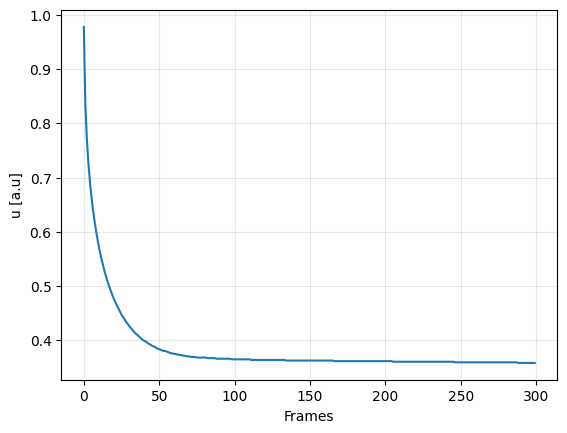

In [10]:
T,Y,X=temp.shape
y_center=Y//2
x_center=X//2
u_np=temp[34:,y_center,x_center]
plt.plot(u)
plt.xlabel('Frames')
plt.ylabel('u [a.u]')
plt.grid(alpha=0.3)

In [11]:
print(f"Temp min: {u_np.min()} | Temp max: {u_np.max()}")

Temp min: 0.35792951541850226 | Temp max: 0.9779735682819384


In [60]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

        a_phys=1e-6
        # Defining our diffusivity via logarithmic mapping
        self.a = nn.Parameter(
    torch.log(torch.tensor(a_phys, dtype=torch.float32))
)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [59]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(2,1,32,3)

u=torch.from_numpy(u_np).to(torch.float32).view(-1,1)

In [35]:
t=torch.linspace(0,10,300).view(-1,1)
x_boundary=torch.zeros_like(u)

x_data=torch.hstack([t,x_boundary])
x_boundary_back=torch.tensor([0.0,0.1,10.0,0.1]).view(-1,2)
X=torch.vstack([x_data,x_boundary_back])

In [43]:
u_back=torch.tensor([0.0,u[-1]]).view(-1,1)
u_back
Y=torch.vstack([u,u_back])

In [46]:
# Collocation points
res=100 # Resolution parameter to our solution
time_res=300
z_coll=torch.linspace(0,0.005,res)
t_coll=torch.linspace(0,10,time_res)

# Torch meshgrid only accept 1d tensors as input
T, X = torch.meshgrid(t_coll, z_coll, indexing='ij')
X_coll = torch.stack([T.reshape(-1), X.reshape(-1)], dim=1)
X_coll.size()


torch.Size([30000, 2])

In [ ]:
X=X.requires_grad_(True)
Y=Y.requires_grad_(True)
X_coll=X_coll.requires_grad_(True)



torch.Size([10000, 2])

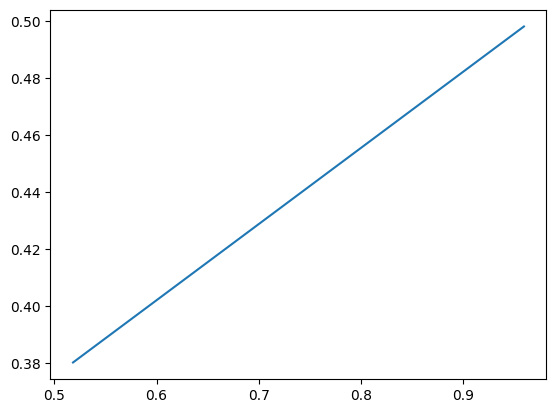

In [ ]:
n_epoch=15001
optimiser=optim.Adam(pinn.parameters(),lr=1e-3)
for i in tqdm(range(n_epoch)):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1, lambda2 = 1e-1, 1e-4
